In [1]:
import voxcell
import numpy
import json
import h5py
import pandas

from matplotlib import pyplot as plt


# Paths to data.
# Make sure that all voxel datasets have the same resolution.

# A file that translates region ids to names and provides their hierarchy.
# Obtain Table S2 from the article https://www.sciencedirect.com/science/article/pii/S0092867420304025#mmc2
# then convert the excel file to .csv. That is the file
fn_hier = "1-s2.0-S0092867420304025-mmc2.csv"
# Part of AIBS CCFv3. Region annotations.
# See https://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation
fn_ann = "annotation_100.nrrd" 
# fn_ann = "annotation_10.nrrd" 

fn_allen_shaped = "reshaped_10um_fm_at_100um.nrrd" # Our proposed flatmap.
fn_area_pres = "10um_fm_at_100um.nrrd"

fn_allen = "dorsal_flatmap_paths_100.h5" # https://github.com/AllenInstitute/mouse_connectivity_models/tree/master/mcmodels/core/cortical_coordinates
#fn_allen = "dorsal_flatmap_paths_10.h5"
# Load annotations and flatmaps
ann = voxcell.VoxelData.load_nrrd(fn_ann)

Next, we load the region hierarchy and take out its lowest level.

That is, because the lowest level in cortical regions indicates individual layers of a given region. Here, we are not interested in layers, only the regions themselves. So we remove that lowest level from the hierarchy and annotations.

In [2]:
def structures_file_to_tree(fn_struc, fltr_str):
    struc_raw = pandas.read_csv(fn_struc, skiprows=1)
    cols_to_keep = dict({
        "structure ID": "id",
        "full structure name": "name",
        "abbreviation": "acronym",
        "structure_id_path": "structure_id_path"
    })
    struc_raw = struc_raw[list(cols_to_keep.keys())].rename(columns=cols_to_keep)
    struc_raw["structure_id_path"] = struc_raw["structure_id_path"].apply(lambda _x: list(map(int, _x.split("/")[1:-1])))

    struc = list(struc_raw.apply(lambda _row: dict(_row.items()), axis=1))
    return structures_to_tree(struc, fltr_str), struc


def structures_to_tree(struc, fltr_str):
    def insert(t, lst_ids):
        assert lst_ids[0] == t[0]
        if len(lst_ids) > 1:
            match = None
            for child in t[1]:
                if child[0] == lst_ids[1]:
                    match = child
                    break
            if match is None:
                child = [lst_ids[1], []]
                t[1].append(child)
            insert(child, lst_ids[1:])
    
    assert len(struc[0]["structure_id_path"]) == 1, "First entry must be the root!"
    tree = [struc[0]["id"], []]
    for entry in struc[1:]:
        if fltr_str in entry["name"]:
            insert(tree, entry["structure_id_path"])

    return tree

def subtree(tree, at_id):
    if len(tree) == 0: return None
    if tree[0] == at_id: return tree
    cand = [subtree(_x, at_id) for _x in tree[1]]
    cand = [_x for _x in cand if _x is not None]
    if len(cand) > 0: return cand[0]
    return None

def truncate_leaf_annotations(tree, ann):
    for _x in tree[1]:
        if len(_x[1]) == 0:
            ann.raw[ann.raw == _x[0]] = tree[0]
        else:
            truncate_leaf_annotations(_x, ann)

def flatten(tree):
    ret = [tree[0]]
    for t in tree[1]:
        ret.extend(flatten(t))
    return ret

# Create a tree of region hierarchies
tree, struc = structures_file_to_tree(fn_hier, "")

# Remove the lowest hierarchy level, which is layers
truncate_leaf_annotations(tree, ann)

# Annotation values for cortical regions
id_ctx = [_x["id"] for _x in struc if _x["acronym"] == "Isocortex"][0]
tgt_ids = flatten(subtree(tree, id_ctx))
tgt_ids = [_x for _x in tgt_ids if _x in ann.raw]

id_2_acronym = dict([(_s["id"], _s["acronym"]) for _s in struc])
tgt_acronyms = [id_2_acronym[_id] for _id in tgt_ids]

# Step 1:
convert both flatmap representations to a pandas.DataFrame with the same representation.
Columns: "x", "y", "z", "pxl_x", "pxl_y", "idx", "ann". Each row corresponds to a mapped voxel. There can be multiple rows for a voxel, if it is mapped to multiple pixels.

"x", "y", "z" are the indices of a voxel in the 3d voxel map.

"pxl_x", "pxl_y" are the coordinates of the pixel a voxel is mapped to.

"idx" is the 1d index of a voxel, i.e. its index after flattening the 3d voxel map (numpy.flatten).

"ann" is the region annotation for that voxel.

## For nrrd-based flatmaps

In [3]:
def nrrd_flatmap_to_pandas(fm, ann):
    Y, X, Z = numpy.meshgrid(numpy.arange(fm.raw.shape[1]),
                             numpy.arange(fm.raw.shape[0]),
                             numpy.arange(fm.raw.shape[2]))

    pd_fm = pandas.DataFrame(
        {
            "x": X.flatten(),
            "y": Y.flatten(),
            "z": Z.flatten(),
            "pxl_y": fm.raw[:, :, :, 0].flatten(),
            "pxl_x": fm.raw[:, :, :, 1].flatten(),
            "idx": numpy.arange(numpy.prod(X.shape))
        }
    ).replace(-1, numpy.NaN)

    # Add region annotations. Use the linear index for that purpose.
    pd_fm["ann"] = ann.raw.flatten()[pd_fm["idx"]]
    return pd_fm


## For path-based flatmaps

In [4]:
def paths_flatmap_to_pandas(pxl_lo, fm_paths, ann, pd_reference_flatmap):
    # From pixel coordinates to path ids
    pxl_y, pxl_x = numpy.meshgrid(numpy.arange(pxl_lo.shape[1]), numpy.arange(pxl_lo.shape[0]))
    path2pxl = pandas.DataFrame({"pxl_x": pxl_x.flatten(), "pxl_y": pxl_y.flatten()},
                                index=pandas.Index(pxl_lo.flatten(), name="path"))
    # A path id < 0 indicates no path, i.e. no voxels mapped to that pixel
    path2pxl = path2pxl[path2pxl.index >= 0]

    # From path ids to linear voxel ids
    #  fm_path: Index along the first dimension corresponds to the path id.
    #  Values in a row indicate linear voxel indices + 1. Rows are padded with "0" for equal length.
    _, path_id = numpy.meshgrid(numpy.arange(fm_paths.shape[1]), numpy.arange(fm_paths.shape[0]))
    path_id2idx = pandas.Series(fm_paths.flatten(), name="idx", index=pandas.Index(path_id.flatten(), name="path")) - 1
    path_id2idx = path_id2idx[path_id2idx >= 0]

    # Put it all together: First, columns "pxl_x", "pxl_y", "idx".
    pd_fm = pandas.concat([path2pxl.loc[path_id2idx.index], path_id2idx], axis=1).reset_index(drop=True)
    # Next "x", "y", "z"
    pd_fm = pandas.concat([
        # Can look up the x, y, z values from the linear coordinates using pd_fm_1, because that lookup is flatmap-independent
        pd_reference_flatmap.set_index("idx")[["x", "y", "z"]].loc[pd_fm["idx"].values].reset_index(drop=True),
        pd_fm
    ], axis=1)
    # Finally: "ann"
    pd_fm["ann"] = ann.raw.flatten()[pd_fm["idx"]]
    return pd_fm


### Read and convert flatmaps

In [5]:
# Ours
pd_fm_area = nrrd_flatmap_to_pandas(voxcell.VoxelData.load_nrrd(fn_area_pres), ann)
pd_fm_shape = nrrd_flatmap_to_pandas(voxcell.VoxelData.load_nrrd(fn_allen_shaped), ann)

# Allen reference
with h5py.File(fn_allen, "r") as h5:
    pxl_lo = h5["view lookup"][:]
    fm_paths = h5["paths"][:]
pd_fm_ref = paths_flatmap_to_pandas(pxl_lo, fm_paths, ann, pd_fm_area)

# Now we remove NaN values for convenience. I.e. voxels that are not flat-mapped.
pd_fm_area = pd_fm_area.loc[~numpy.isnan(pd_fm_area).any(axis=1)]
pd_fm_shape = pd_fm_shape.loc[~numpy.isnan(pd_fm_shape).any(axis=1)]

# Only consider parts that are flattened in the reference
mask = numpy.isin(pd_fm_area["idx"], pd_fm_ref["idx"])
pd_fm_area = pd_fm_area.loc[mask]
mask = numpy.isin(pd_fm_shape["idx"], pd_fm_ref["idx"])
pd_fm_shape = pd_fm_shape.loc[mask]

display(pd_fm_ref["idx"].value_counts()) # Note: voxels can be assigned to multiple pixels in the Allen flatmap!

idx
313681    202
313658    202
304424    176
304447    176
313567    144
         ... 
385229      1
621443      1
630792      1
611866      1
278432      1
Name: count, Length: 131820, dtype: int64

## Visualize the coordinates of one flatmap in another
It returns for each pixel in one flatmap the mean pixel value (x or y) in the other flatmap

In [6]:
def visualize_flatmap_in_other_flatmap(fm_use, fm_show, prop_to_show,
                                       props_to_use=["pxl_x", "pxl_y"], prop_to_match="idx"):
    mask = numpy.isin(fm_use[prop_to_match], fm_show[prop_to_match])
    fm_use = fm_use.loc[mask].set_index(prop_to_match)
    
    viz = fm_show.groupby(prop_to_match)[prop_to_show].mean()
    viz = viz[fm_use.index]
    viz.name = "viz"
    M = pandas.concat([fm_use, viz], axis=1).groupby(props_to_use)["viz"].mean()
    return M.unstack(props_to_use[1])

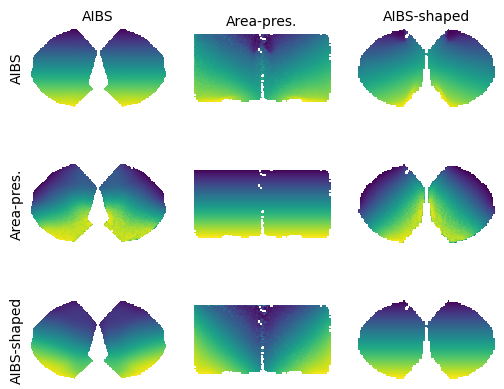

In [42]:
fig = plt.figure(figsize=(6, 5))
labels = ["AIBS", "Area-pres.", "AIBS-shaped"]

for i, pd_fm_1 in enumerate([pd_fm_ref, pd_fm_area, pd_fm_shape]):
    for j, pd_fm_2 in enumerate([pd_fm_ref, pd_fm_area, pd_fm_shape]):
        ax = fig.add_subplot(3, 3, 3 * i + j + 1)
        ax.imshow(visualize_flatmap_in_other_flatmap(pd_fm_2, pd_fm_1, "pxl_x"))
        # ax.set_ylabel("pixel: y")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_frame_on(False)
        if i == 0: ax.set_title(labels[j], fontsize=10)
        if j == 0: ax.set_ylabel(labels[i])
fig.savefig("comparing_flatmap_coordinates_100um.pdf")

## Comparing how region annotations are represented 

In [44]:
# For each pixel we use the region annotation that has the plurality of voxels associated with the pixel
def get_consensus(v_in):
    return v_in.value_counts().index[0]

# Turns the random values of the region annotations to consecutive integers. Values not in the reference set to NaN
def reindex_values(v_in, reference):
    is_valid = numpy.isin(v_in.values, reference)
    bins = numpy.hstack([numpy.unique(reference), numpy.max(reference) + 1])
    ret = pandas.Series(
        numpy.digitize(v_in.values, bins=bins) - 1,
        index=v_in.index, name=v_in.name
    )
    ret[~is_valid] = numpy.NaN
    return ret


Mref = pd_fm_ref.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_consensus)
Marea = pd_fm_area.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_consensus)
Mshape = pd_fm_shape.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_consensus)

Mref = reindex_values(Mref, tgt_ids)
Marea = reindex_values(Marea, tgt_ids)
Mshape = reindex_values(Mshape, tgt_ids)

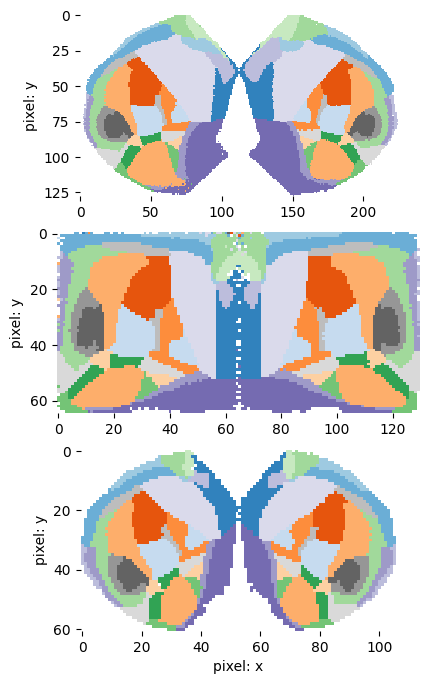

In [45]:
fig = plt.figure(figsize=(5, 8))

ax = fig.add_subplot(3, 1, 1)
ax.imshow(Mref.unstack("pxl_y"), cmap="tab20c", interpolation="nearest")
ax.set_ylabel("pixel: y")
ax.set_frame_on(False)

ax = fig.add_subplot(3, 1, 2)
ax.imshow(Marea.unstack("pxl_y"), cmap="tab20c", interpolation="nearest")
ax.set_ylabel("pixel: y")
ax.set_frame_on(False)

ax = fig.add_subplot(3, 1, 3)
ax.imshow(Mshape.unstack("pxl_y"), cmap="tab20c", interpolation="nearest")
ax.set_ylabel("pixel: y")
ax.set_xlabel("pixel: x")
ax.set_frame_on(False)

fig.savefig("comparing_region_annotations_100um.pdf")

# How well do the flatmaps represent the actual geometry?

First, how well are the sizes of regions represented by their sizes in each flatmap?

In [46]:
# We run these lines again, because for this analysis we need the actual region ids, not consecutive integers.
Mref = pd_fm_ref.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_consensus)
Marea = pd_fm_area.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_consensus)
Mshape = pd_fm_shape.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_consensus)

AIBS           0.906069
Area-pres.     0.891296
AIBS-shaped    0.876873
voxels         1.000000
Name: voxels, dtype: float64


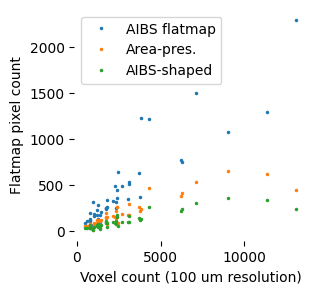

In [54]:
# For each region id: How many pixels are associated with it in each of the flat maps?
ann_cmp = pandas.concat([Mref.value_counts().sort_index(),
                         Marea.value_counts().sort_index(),
                        Mshape.value_counts().sort_index()],
                        axis=1, keys=labels)
# Filter to only consider cortical regions...
ann_cmp = ann_cmp.loc[tgt_ids]
# For comparison: How many voxels are associated with each region?
ann_cmp["voxels"] = [(ann.raw == _i).sum() for _i in ann_cmp.index]

fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

ax.plot(ann_cmp["voxels"], ann_cmp["AIBS"], '.', ms=3, label="AIBS flatmap")
ax.plot(ann_cmp["voxels"], ann_cmp["Area-pres."], '.', ms=3,label="Area-pres.")
ax.plot(ann_cmp["voxels"], ann_cmp["AIBS-shaped"], '.', ms=3,label="AIBS-shaped")
ax.set_xlabel("Voxel count (100 um resolution)")
ax.set_ylabel("Flatmap pixel count")
ax.set_frame_on(False)

plt.legend()

print(ann_cmp.corr()["voxels"])
fig.savefig("comparing_area_vs_voxel_counts.pdf")

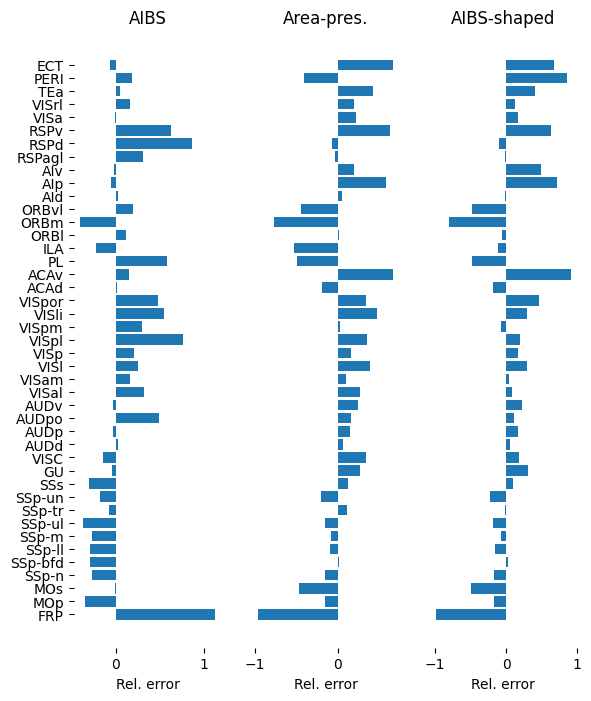

In [48]:
def region_size_prediction_error(df, col_x, col_y):
    a, b = numpy.polyfit(df[col_x], df[col_y], 1)
    err = a * df[col_x] + b - ann_cmp[col_y]
    rel_err = err / ann_cmp[col_y]
    rel_err.name = col_x
    return rel_err

rel_err = pandas.concat([
    region_size_prediction_error(ann_cmp, "AIBS", "voxels"),
    region_size_prediction_error(ann_cmp, "Area-pres.", "voxels"),
    region_size_prediction_error(ann_cmp, "AIBS-shaped", "voxels")
], axis=1)

fig = plt.figure(figsize=(6.5, 8))

ax = fig.add_subplot(1, 3, 1)
ax.barh(range(len(rel_err)), rel_err["AIBS"])
ax.set_frame_on(False)
ax.set_yticks(range(len(rel_err)))
_ = ax.set_yticklabels(tgt_acronyms)
ax.set_title("AIBS")
ax.set_xlabel("Rel. error")

ax = fig.add_subplot(1, 3, 2)
ax.barh(range(len(rel_err)), rel_err["Area-pres."])
ax.set_frame_on(False)
ax.set_yticks([])
ax.set_title("Area-pres.")
ax.set_xlabel("Rel. error")

ax = fig.add_subplot(1, 3, 3)
ax.barh(range(len(rel_err)), rel_err["AIBS-shaped"])
ax.set_frame_on(False)
ax.set_yticks([])
ax.set_title("AIBS-shaped")
ax.set_xlabel("Rel. error")

fig.savefig("comparing_area_vs_voxel_count_errors.pdf")

Second: Neighborhood relations: How well are the sizes of the borders between regions represented?

In [26]:
# For each pair of region ids i and j: How many neighboring pixels / voxels are there, 
# such that one has value i and the other value j?
# We consider direct neighbors, not diagonal ones. That is: four neighbors in the 2d case,
# 6 neighbors in the 3d case.
def get_border_counts(annotations, tgt_ids):
    border_counts = []
    for rid1 in tgt_ids:
        main_mask = annotations == rid1
        if main_mask.ndim == 3:
            neighbor_ann = numpy.hstack([
                annotations[:, :, 1:][main_mask[:, :, :-1]],
                annotations[:, :, :-1][main_mask[:, :, 1:]],
                annotations[:, 1:, :][main_mask[:, :-1, :]],
                annotations[:, :-1, :][main_mask[:, 1:, :]],
                annotations[1:, :, :][main_mask[:-1, :, :]],
                annotations[:-1, :, :][main_mask[1:, :, :]]
            ])
        elif main_mask.ndim == 2:
            neighbor_ann = numpy.hstack([
                annotations[:, 1:][main_mask[:, :-1]],
                annotations[:, :-1][main_mask[:, 1:]],
                annotations[1:, :][main_mask[:-1, :]],
                annotations[:-1, :][main_mask[1:, :]]
            ])
        else: raise ValueError()
        border_counts.append(pandas.Series(neighbor_ann, name="neighbors").value_counts().drop(rid1))

    border_counts = pandas.concat(border_counts, axis=0, keys=tgt_ids, names=["region"])
    border_counts_mat = border_counts.unstack("neighbors", fill_value=0)[tgt_ids]
    return border_counts_mat

border_3d = get_border_counts(ann.raw, tgt_ids)
border_2d_ref = get_border_counts(Mref.unstack("pxl_y").values.astype(int), tgt_ids)
border_2d_area = get_border_counts(Marea.unstack("pxl_y").values.astype(int), tgt_ids)
border_2d_shape = get_border_counts(Mshape.unstack("pxl_y").values.astype(int), tgt_ids)

/nvme/reimann/2143302/ipykernel_218197/96737810.py:33: RuntimeWarning: invalid value encountered in cast
  border_2d_ref = get_border_counts(Mref.unstack("pxl_y").values.astype(int), tgt_ids)
/nvme/reimann/2143302/ipykernel_218197/96737810.py:34: RuntimeWarning: invalid value encountered in cast
  border_2d_area = get_border_counts(Marea.unstack("pxl_y").values.astype(int), tgt_ids)
/nvme/reimann/2143302/ipykernel_218197/96737810.py:35: RuntimeWarning: invalid value encountered in cast
  border_2d_shape = get_border_counts(Mshape.unstack("pxl_y").values.astype(int), tgt_ids)


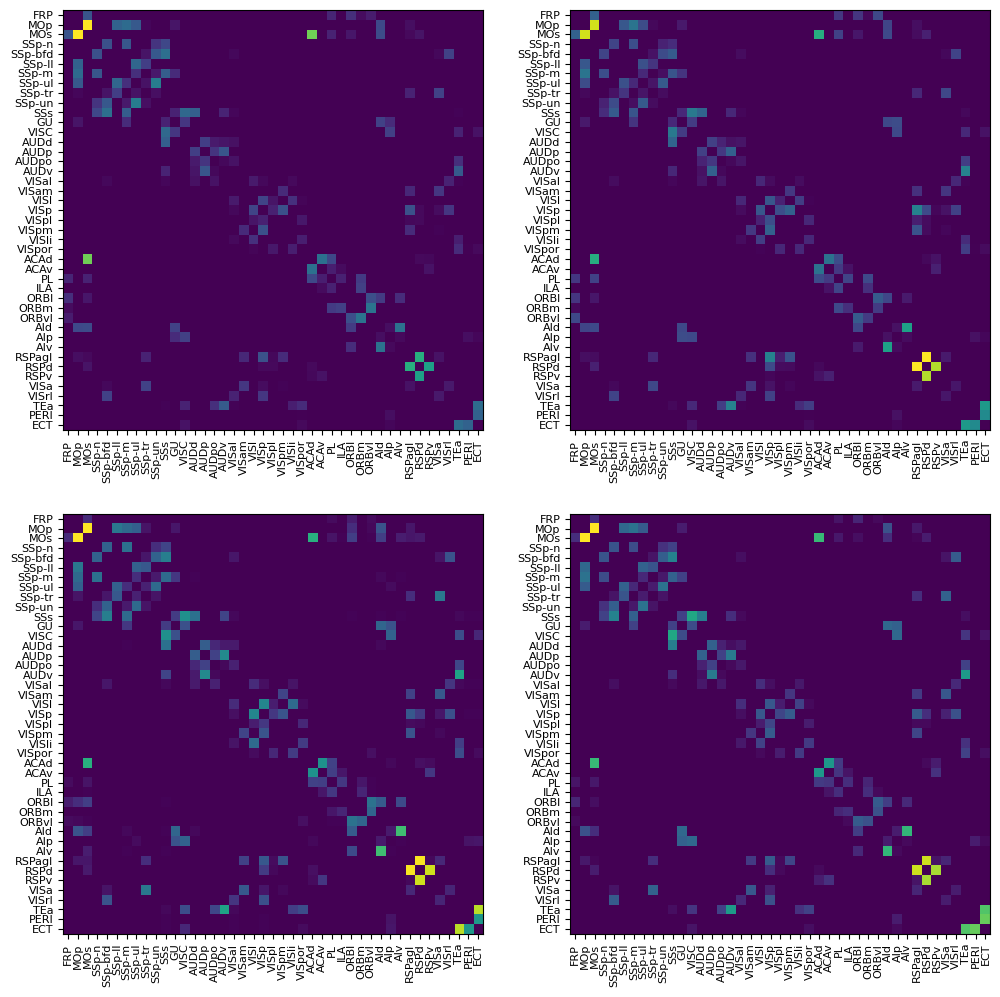

In [28]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(2, 2, 1)
ax.imshow(border_3d)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")

ax = fig.add_subplot(2, 2, 2)
ax.imshow(border_2d_ref)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")

ax = fig.add_subplot(2, 2, 3)
ax.imshow(border_2d_area)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")

ax = fig.add_subplot(2, 2, 4)
ax.imshow(border_2d_shape)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")


array([1.        , 0.94810692, 0.93717811, 0.94580565])

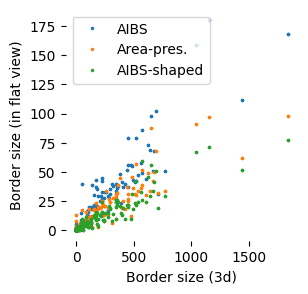

In [55]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

ax.plot(border_3d.values.flatten(), border_2d_ref.values.flatten(), '.', ms=3, label="AIBS")
ax.plot(border_3d.values.flatten(), border_2d_area.values.flatten(), '.', ms=3, label="Area-pres.")
ax.plot(border_3d.values.flatten(), border_2d_shape.values.flatten(), '.', ms=3, label="AIBS-shaped")

ax.set_xlabel("Border size (3d)")
ax.set_ylabel("Border size (in flat view)")
ax.set_frame_on(False)

plt.legend()

fig.savefig("comparing_border_sizes.pdf")

numpy.corrcoef([border_3d.values.flatten(),
               border_2d_ref.values.flatten(),
                border_2d_area.values.flatten(),
               border_2d_shape.values.flatten()])[0]

### Uniformity of voxels per pixel

The true size of regions is likely to be represented correctly, if the number of voxels mapping to a pixel is somewhat uniform.
It is expected to vary slightly, due to variability of cortical thickness.

We note that a flatmap that maps one voxel to multiple pixels has an easier time being uniform in this measure...

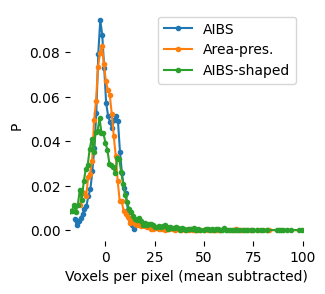

In [50]:
vox_per_pxl_ref = pd_fm_ref.groupby(["pxl_x", "pxl_y"])["idx"].count()
vox_per_pxl_ref = (vox_per_pxl_ref - vox_per_pxl_ref.mean()).value_counts(normalize=True).sort_index()

vox_per_pxl_area = pd_fm_area.groupby(["pxl_x", "pxl_y"])["idx"].count()
vox_per_pxl_area = (vox_per_pxl_area - vox_per_pxl_area.mean()).value_counts(normalize=True).sort_index()

vox_per_pxl_shape = pd_fm_shape.groupby(["pxl_x", "pxl_y"])["idx"].count()
vox_per_pxl_shape = (vox_per_pxl_shape - vox_per_pxl_shape.mean()).value_counts(normalize=True).sort_index()

plt.figure(figsize=(3, 3))

plt.plot(vox_per_pxl_ref, marker='.', label="AIBS")
plt.plot(vox_per_pxl_area, marker='.', label="Area-pres.")
plt.plot(vox_per_pxl_shape, marker='.', label="AIBS-shaped")

plt.gca().set_xlim([-18, 100])
plt.gca().set_xlabel("Voxels per pixel (mean subtracted)")
plt.gca().set_ylabel("P")
plt.gca().set_frame_on(False)
plt.legend()

fig.savefig("comparing_voxels_per_pixel_100um.pdf")

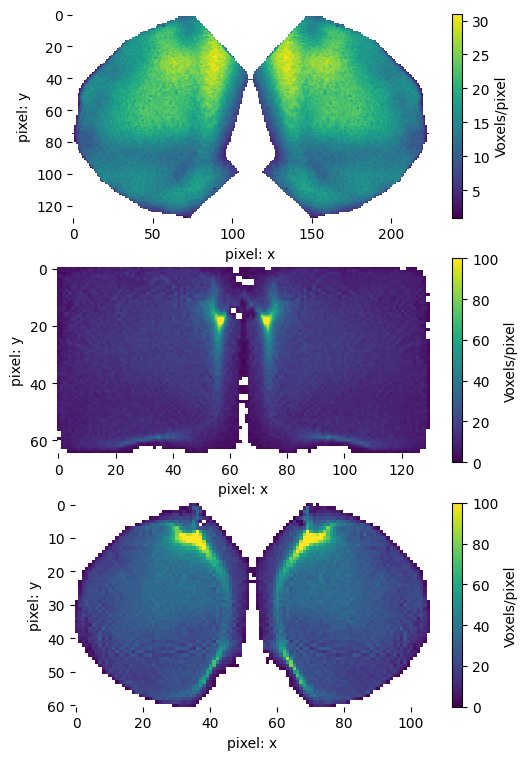

In [51]:
fig = plt.figure(figsize=(6, 9))

ax = fig.add_subplot(3, 1, 1)
plt.colorbar(ax.imshow(pd_fm_ref.groupby(["pxl_x", "pxl_y"])["idx"].count().unstack("pxl_y")),
            label="Voxels/pixel")
ax.set_frame_on(False)
ax.set_xlabel("pixel: x"); ax.set_ylabel("pixel: y")

ax = fig.add_subplot(3, 1, 2)
plt.colorbar(ax.imshow(pd_fm_area.groupby(["pxl_x", "pxl_y"])["idx"].count().unstack("pxl_y"), clim=[0, 100]),
            label="Voxels/pixel")
ax.set_frame_on(False)
ax.set_xlabel("pixel: x"); ax.set_ylabel("pixel: y")

ax = fig.add_subplot(3, 1, 3)
plt.colorbar(ax.imshow(pd_fm_shape.groupby(["pxl_x", "pxl_y"])["idx"].count().unstack("pxl_y"), clim=[0, 100]),
            label="Voxels/pixel")
ax.set_frame_on(False)
ax.set_xlabel("pixel: x"); ax.set_ylabel("pixel: y")

fig.savefig("comparing_voxels_per_pixel_image_100um.pdf")

## How well are the relative orientations of regions towards each other captured?

We would like regions that are aligned along a given axis of the brain to also show up along a line in the flat view.

To that end, we consider the orientations of pairs of regions to each other in the flat view. Specifically, we represent each region by its center (i.e. its average "pxl_x", "pxl_y" value). Then we consider as the orientation of the pair of regions to each other: the angle between the line connecting their centers and the vertical.

We compare this to the primitive flatmap that one gets by stripping away the "y" coordinate. That primitive flatmap should provide a robust idea of the actual orientation. 

All of this simplifies man aspects, but should provide a heurisitcal view of how well relative orientations are represented.

In [34]:
def calculate_pairwise_orientations(pd_fm, cols, tgt_ids):
    # Centers are simply the average coordinate values
    centers = pd_fm.groupby("ann")[cols].mean().loc[tgt_ids]
    
    # All pairwise offsets between centers
    d_center = centers.values.reshape((-1, 1, 2)) - centers.values.reshape((1, -1, 2))
    
    # Calculate angles using arctan2
    angles = numpy.arctan2(d_center[:, :, 0], d_center[:, :, 1]).flatten()
    
    return angles

# Results will be between -pi and pi. However, since the angle representations is cyclic,
# an angle x + 2 pi is the same as x. We add / subtract 2 pi where it provides a better fit
def correct_2pi_offset(df_in, col_fix, col_ref):
    mask_add_2pi = df_in[col_fix] - df_in[col_ref] < -numpy.pi
    mask_sub_2pi = df_in[col_fix] - df_in[col_ref] > numpy.pi
    df_in[col_fix][mask_add_2pi] += 2 * numpy.pi
    df_in[col_fix][mask_sub_2pi] -= 2 * numpy.pi

centerline = int(ann.raw.shape[2]/2) # For this analysis we only consider the right hemisphere

mask = (pd_fm_ref["z"] >= centerline)
angles_fm_ref = pandas.DataFrame({
    "flatmap": calculate_pairwise_orientations(pd_fm_ref[mask], ["pxl_x", "pxl_y"], tgt_ids),
    "3d": calculate_pairwise_orientations(pd_fm_ref[mask], ["x", "z"], tgt_ids)
})
correct_2pi_offset(angles_fm_ref, "flatmap", "3d")

mask = (pd_fm_area["z"] >= centerline)
angles_fm_area = pandas.DataFrame({
    "flatmap": calculate_pairwise_orientations(pd_fm_area[mask], ["pxl_x", "pxl_y"], tgt_ids),
    "3d": calculate_pairwise_orientations(pd_fm_area[mask], ["x", "z"], tgt_ids)
})
correct_2pi_offset(angles_fm_area, "flatmap", "3d")

mask = (pd_fm_shape["z"] >= centerline)
angles_fm_shape = pandas.DataFrame({
    "flatmap": calculate_pairwise_orientations(pd_fm_shape[mask], ["pxl_x", "pxl_y"], tgt_ids),
    "3d": calculate_pairwise_orientations(pd_fm_shape[mask], ["x", "z"], tgt_ids)
})
correct_2pi_offset(angles_fm_shape, "flatmap", "3d")

# A global rotation of the flatmap will show up as a constant offset of all angles.
# Such a global rotation is no big deal and is not what we want to consider an error.
# Thus, we calculate an optimal offset for the "flatmap" angles and calculate the error taking the offset into account.
global_rotation_ref = angles_fm_ref.diff(axis=1)["3d"].mean()
err_ref = numpy.abs(angles_fm_ref["flatmap"] - angles_fm_ref["3d"] + global_rotation_ref)

global_rotation_area = angles_fm_area.diff(axis=1)["3d"].mean()
err_area = numpy.abs(angles_fm_area["flatmap"] - angles_fm_area["3d"] + global_rotation_area)

global_rotation_shape = angles_fm_shape.diff(axis=1)["3d"].mean()
err_shape = numpy.abs(angles_fm_shape["flatmap"] - angles_fm_shape["3d"] + global_rotation_shape)

0.21465530634726857 0.2593085990801676 0.19465347359217003


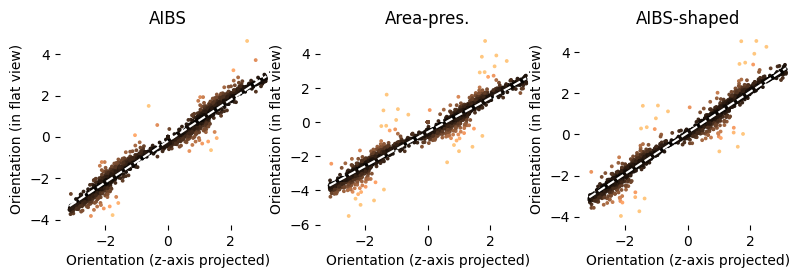

In [52]:
fig = plt.figure(figsize=(9.5, 2.5))
ax = fig.add_subplot(1, 3, 1)

ax.scatter(angles_fm_ref["3d"], angles_fm_ref["flatmap"], 3, err_ref, clim=[0, numpy.pi / 2], cmap="copper")
# As visual reference we indicate a perfect fit (identity).
# It also takes the global rotation (offset) into account
ax.plot([-numpy.pi, numpy.pi], [-numpy.pi, numpy.pi] - global_rotation_ref,
        color="white", ls="--")
ax.set_title("AIBS")
ax.set_xlabel("Orientation (z-axis projected)")
ax.set_ylabel("Orientation (in flat view)")
ax.set_frame_on(False)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(angles_fm_area["3d"], angles_fm_area["flatmap"], 3, err_area, clim=[0, numpy.pi / 2], cmap="copper")
# As visual reference we indicate a perfect fit (identity).
# It also takes the global rotation (offset) into account
ax.plot([-numpy.pi, numpy.pi], [-numpy.pi, numpy.pi] - global_rotation_area,
        color="white", ls="--")
ax.set_title("Area-pres.")
ax.set_xlabel("Orientation (z-axis projected)")
ax.set_ylabel("Orientation (in flat view)")
ax.set_frame_on(False)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(angles_fm_shape["3d"], angles_fm_shape["flatmap"], 3, err_shape, clim=[0, numpy.pi / 2], cmap="copper")
# As visual reference we indicate a perfect fit (identity).
# It also takes the global rotation (offset) into account
ax.plot([-numpy.pi, numpy.pi], [-numpy.pi, numpy.pi] - global_rotation_shape,
        color="white", ls="--")
ax.set_title("AIBS-shaped")
ax.set_xlabel("Orientation (z-axis projected)")
ax.set_ylabel("Orientation (in flat view)")
ax.set_frame_on(False)

fig.savefig("comparing_representation_of_orientations.pdf")

print(err_ref.mean(), err_area.mean(), err_shape.mean())

## Use case: Volume decomposition.

So far, we presented metrics where the AIBS flatmap is just ever so slightly better than ours. That is, because our flatmap was built with an intentional constraint: Each voxel was to be mapped to only one single pixel.

This enables an important use case: Decomposition of the mapped volume into disjunct sub-volumes. 

We demonstrate this by attempting volume decomposition and then calculating how much neighboring sub-volumes overlap. We perform volume decomposition by first building a decomposition of the pixels, then taking their pre-images.

In [38]:
def digitize_uniform_bin_size(data_in, bin_sz):
    bins = numpy.arange(0, data_in.max() + bin_sz, bin_sz)
    return numpy.digitize(data_in, bins=bins) - 1


def decompose_and_count_overlap(pd_df, bin_sz):
    df = pandas.concat([
        pd_df[["pxl_x", "pxl_y"]].apply(lambda _x: digitize_uniform_bin_size(_x, bin_sz), axis=0),
        pd_df["idx"]
    ], axis=1)

    decomposition = df.groupby(["pxl_x", "pxl_y"])["idx"].apply(list)
    frac_non_unique = pandas.Series(
        [numpy.in1d(_val, numpy.hstack(decomposition.drop(_idx).values)).mean()
         for _idx, _val in decomposition.items()],
        index=decomposition.index)
    return frac_non_unique.unstack("pxl_y")

# We decompose the volume into pre-images corresponding to patches of N x N pixels in flat view
show_bin_sz = 5 # This is the value of N. Adjust to try different values.

# Counts the fraction of voxels in the decomposition that are not unique to a given pre-image.
non_unique_ref = decompose_and_count_overlap(pd_fm_ref, show_bin_sz)
non_unique_area = decompose_and_count_overlap(pd_fm_area, show_bin_sz)
non_unique_shape = decompose_and_count_overlap(pd_fm_shape, show_bin_sz)

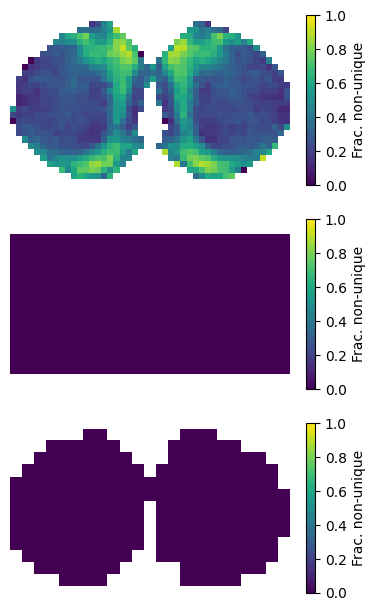

In [53]:
fig = plt.figure(figsize=(4.5, 7.5))

ax = fig.add_subplot(3, 1, 1)
plt.colorbar(ax.imshow(non_unique_ref, clim=[0, 1]),
            label="Frac. non-unique")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(3, 1, 2)
plt.colorbar(ax.imshow(non_unique_area, clim=[0, 1]),
            label="Frac. non-unique")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(3, 1, 3)
plt.colorbar(ax.imshow(non_unique_shape, clim=[0, 1]),
            label="Frac. non-unique")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

fig.savefig("comparing_frac_non_unique_voxels_{0}_pixels.pdf".format(show_bin_sz))

In [90]:
# For the AIBS flatmap: Try different sizes and plot mean +- std of non-unique voxels.
# THIS MAY TAKE A WHILE.
smpl_bin_szs = [1, 2, 5, 10, 15, 20, 25]

def mean_and_std(df_in):
    return pandas.Series([df_in.mean(axis=None), df_in.stack().std()],
                        index=["mean", "std"])

non_unique_series = [
    mean_and_std(decompose_and_count_overlap(pd_fm_2, _bin_sz))
    for _bin_sz in smpl_bin_szs
]
non_unique_series = pandas.concat(non_unique_series, axis=0, keys=smpl_bin_szs).unstack(1)

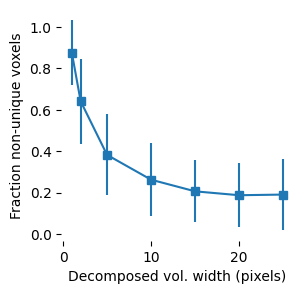

In [97]:

fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

ax.errorbar(non_unique_series.index, non_unique_series["mean"],
            yerr=non_unique_series["std"], marker='s')
ax.set_frame_on(False)
ax.set_xlabel("Decomposed vol. width (pixels)")
ax.set_ylabel("Fraction non-unique voxels")

fig.savefig("frac_non_unique_voxels_various_sizes.pdf")

### Alternative, more complex way of plotting coordinates of one flatmap in the other

In [21]:
a = pd_fm_1["pxl_x"] / pd_fm_1["pxl_x"].max()
b = pd_fm_1["pxl_y"] / pd_fm_1["pxl_y"].max()

cols = pandas.DataFrame({
    "r": a, "g": b, "b": 1.0 - 0.5 * a - 0.5 * b
})
pd_fm_1 = pandas.concat([pd_fm_1, cols], axis=1)

In [22]:
a = pd_fm_2["pxl_x"] / pd_fm_2["pxl_x"].max()
b = pd_fm_2["pxl_y"] / pd_fm_2["pxl_y"].max()

cols = pandas.DataFrame({
    "r": a, "g": b, "b": 1.0 - 0.5 * a - 0.5 * b
})
pd_fm_2 = pandas.concat([pd_fm_2, cols], axis=1)

/gpfs/bbp.cscs.ch/home/reimann/venvs/bpsnap/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/gpfs/bbp.cscs.ch/home/reimann/venvs/bpsnap/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


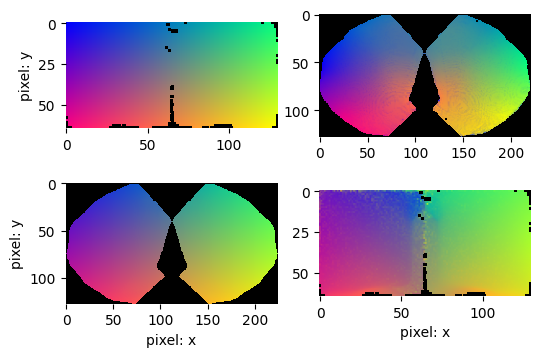

In [23]:
def create_rgb_image(fm_use, fm_show):
    I = numpy.dstack([
        visualize_flatmap_in_other_flatmap(fm_use, fm_show, _prop).values
        for _prop in ["r", "g", "b"]])
    return I

fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(2, 2, 1)
ax.imshow(create_rgb_image(pd_fm_1, pd_fm_1))
ax.set_ylabel("pixel: y")
ax.set_frame_on(False)
ax = fig.add_subplot(2, 2, 2)
ax.imshow(create_rgb_image(pd_fm_2, pd_fm_1))
ax.set_frame_on(False)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(create_rgb_image(pd_fm_2, pd_fm_2))
ax.set_ylabel("pixel: y")
ax.set_xlabel("pixel: x")
ax.set_frame_on(False)
ax = fig.add_subplot(2, 2, 4)
ax.imshow(create_rgb_image(pd_fm_1, pd_fm_2))
ax.set_xlabel("pixel: x")
ax.set_frame_on(False)

fig.savefig("comparing_flatmap_coordinates_colors_100um.pdf")